## I -  Objet : Vocal Isolator - Temporel

## II -  Pré-requis :

- Charger le df_multi_11025hz.npy


## III -  Code :

### III.i - Bibliothèques requises

In [1]:
import os
import re
import subprocess
import pandas as pd
import numpy as np
import glob
import pathlib
import librosa
import matplotlib.pyplot as plt
import torchaudio
import torch
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import swifter
import warnings
warnings.filterwarnings("ignore")

### III.ii - Fonction dédiées

In [2]:
#######################################################################################################
# la fonction qui crée des échantillons disjoints de nb_var features pour une dataframe donné.


def create_data_fast(signal,nb_var):
    
    ECH_mix = [[] for _ in range(nb_var)]                    # la liste amenée à contenir l'ensemble des tables d'échantillons musicaux disjoints

    for k in range(nb_var):                                  # On crée chaque table d'échantillons disjoints (les datas) et on les ajoute à la liste ECH_mix (la liste d'échantillons décalés de 1 pas temporel)
        data=[]                                              # la table d'échantillons contenant un nombre nb_var de pas temporels.
        for i in range(k,len(signal)-nb_var,nb_var):         # pour que chaque échantillons ait le même nombre de valeurs et que chaque table ait le même nombre d'échantillons, il faut tronquer le signal.
            data.append(signal[i:i+nb_var])              
        ECH_mix[k].append(data)                              
        if len (ECH_mix[k][0])>nb_var:
            ECH_mix[k][0]=ECH_mix[k][0][:-1] 
            
    return pd.DataFrame(ECH_mix[0][0])
    
####################################################################################################### 

# la fonction qui, sur la base de deux signaux A et B, crée des échantillons composés de n-1 valeurs du signal A et de la nieme
# valeur du signal B

def prod_df(signal_mix,signal_vocal,n):
    
    ECH_mix = [[] for _ in range(n)]                    

    for k in range(n):                                  
        data=[]                                              
        for i in range(k,len(signal_mix)-n,n):   
            data.append(signal_mix[i:i+n])              
        ECH_mix[k].append(data)                              
        if len (ECH_mix[k][0])>n:
            ECH_mix[k][0]=ECH_mix[k][0][:-1]
            
            
    ECH_vox = [[] for _ in range(n)]            

    for k in range(n):                          
        data=[]
        for i in range(k,len(signal_vocal)-n,n):
            data.append(signal_vocal[i:i+n])      
        ECH_vox[k].append(data)                      
        if len (ECH_vox[k][0])>n:
            ECH_vox[k][0]=ECH_vox[k][0][:-1]
            
    df_mix = pd.DataFrame(ECH_mix[0][0]).drop([n-1],axis = 1)
    df_vox = pd.DataFrame(ECH_vox[0][0]).rename({n-1:'label'},axis = 1)

    for i in range(1,n):
        df_mix = pd.concat([df_mix,pd.DataFrame(ECH_mix[i][0]).drop([n-1],axis = 1)])
        df_vox = pd.concat([df_vox,pd.DataFrame(ECH_vox[i][0]).rename({n-1:'label'},axis = 1)])
    
    return pd.concat([df_mix,df_vox.label],axis = 1)




#######################################################################################################    
# Une fonction qui permet d'ajouter une variable qui va encoder, pour chaque ligne, le nombre de changement de signe

def count(liste):
    count = 0
    for i in range(0,len(liste)-1):
        
        if liste[i] > 0 and liste[i+1]>0:
            count = count
        if liste[i] < 0 and liste[i+1]<0:
            count = count
        if liste[i] < 0 and liste[i+1]>0:
            count +=1
        if liste[i] > 0 and liste[i+1]<0:
            count+=1
    return count


#######################################################################################################
# une fonction qui permet d'ajouter une variable qui va encoder, pour chaque ligne, le nombre d'oscillation

def oscille(liste):
    count = 0
    for i in range(0,len(liste)-2):
        if liste[i] < liste[i+1] and liste[i+1] < liste[i+2]:
            count = count
        if liste[i] > liste[i+1] and liste[i+1] > liste[i+2]:
            count = count
            
            
        if liste[i] < liste[i+1] and liste[i+1] > liste[i+2]:
            count +=1
        if liste[i] > liste[i+1] and liste[i+1] < liste[i+2]:
            count +=1
      
    return count

#######################################################################################################
def periode(liste):   # cf fin de doc pour démo sur une ligne
        
        x = [i for i in range(len(liste))]
        y = liste
        
        x = np.asarray(x)
        y = np.asarray(y)
        
        p4 = np.poly1d(np.polyfit(x,y,20)) # On applique une regression polynomiale sur le nuage de point
        
        valeur = list(p4(x))
        
        position_max_min = []
        
        for i in range(len(valeur)-1): # On récupère la position des maxima de courbes
            if valeur[i-1]< valeur[i] and valeur[i]> valeur[i+1]:
                position_max_min.append(i)
        
        periode = 0
        
        if len(position_max_min)>=2:
            periode = position_max_min[1]-position_max_min[0]
        
        return len(position_max_min)     

    ##########################################################################################################
# la fonction qui produit le ratio audible / durée morceaux:

def ratio(signal_vocal):
    
    duree_total = len(signal_vocal)                                    # le nombre de valeur d'amplitude du morceau
    seuil_vocal = np.where(abs(signal_vocal)> seuil,1,0)               # Si la valeur d'amplitude est au-dessus du seuil -> 1 sinon 0
    df_echantillon_seuil = create_data_fast(seuil_vocal,nb_var)        # Utilisation format Dataframe pour les seuils 
    
    # On somme toutes les valeurs de seuil
    df_echantillon_seuil['somme'] =  df_echantillon_seuil.sum(axis = 1)
    
    # Si la somme est nulle ( i.e si aucune valeur n'est au dessus du seuil, alors on est en présence d'inaudible)
    # A l'inverse, si une seule valeur est au dessus, alors on consdière que le tronçon entier est constitutif d'un
    # passage audible
    
    df_echantillon_seuil['label'] = df_echantillon_seuil['somme'].apply(lambda x : 0 if x ==0 else 1)
    
    silence = df_echantillon_seuil['label'][df_echantillon_seuil['label']==0]
    audible = df_echantillon_seuil['label'][df_echantillon_seuil['label']==1]
    return  len(audible)/ (len(audible)+len(silence))

### III.iii - Constantes à fixer à priori

In [3]:
nb_var = 10      # Le nombre de pas de temps constitutif des échantillons
seuil = 0.01      # le seuil permettant de séparer la voix de la non voix pour un ensemble de nb_var consécutif
nb_morceau = 5    # le nombre de morceaux exploités dans ce notebook

### III.iv - Développement

- On charge le dataframe contenant les signaux

In [4]:
check = np.load('df_multi_11025hz.npy', allow_pickle=True )
df = pd.DataFrame(check,columns = ['Id', 'Artiste_Morceau', 'Style', 'bass', 'drums', 'mixture', 'other',
       'vocals'])

- On produit la liste identique à celle utilisée pour le VAD

In [5]:


sel = [47,1,44,43,63,48,64,65]

# nb_var morceaux de 30s en canal mixture  
signal_mix = df.loc[0,'mixture']
for i in sel:
    signal_mix = np.concatenate([signal_mix,df.loc[i,'mixture']])

# nb_var morceaux de 30s en canal vocal, correspondant aux précédants
signal_vocal = df.loc[0,'vocals']
for i in sel:
    signal_vocal = np.concatenate([signal_vocal,df.loc[i,'vocals']])



## PARTIE Voice Isolator

On entraine un nouvel algorithme sur la base des seuls échantillon identifié comme voix.

### Principe retenu:

Reconstruire un signal vocal à partir de k prédictions réalisées sur k échantillons composés de n valeurs d'amplitude. Pour un échantillon k donné, n-1 valeurs consécutives sont issues du mix et la nième est tirée du vocal, avec une parfaite correpondance entre les pas temporels de chaque signaux

Il faut ainsi produire: 
- une base d'échantillon de mixture identifié tel que voix
- une base d'échantillon de voix identifié tel que voix

On reprend la même base signal_mix et signal_vocal du début, en recomposant l'ensemble avec de nouveau nom. 

In [6]:
# On réalise les étapes permettant d'obtenir la liste des index d'échantillon mute

VI_seuil_vocal = np.where(abs(signal_vocal)>seuil,1,0)

VI_df_echantillon_mixture = create_data_fast(signal_mix,nb_var)
VI_df_echantillon_vocal = create_data_fast(signal_vocal,nb_var)
VI_df_echantillon_seuil = create_data_fast(VI_seuil_vocal,nb_var)


VI_df_echantillon_seuil['somme'] = VI_df_echantillon_seuil.sum(axis = 1)   # On somme tous les seuils
VI_df_echantillon_seuil['label'] = VI_df_echantillon_seuil['somme'].apply(lambda x : 0 if x ==0 else 1) # On filtre et labelise

to_drop = VI_df_echantillon_seuil[VI_df_echantillon_seuil['label']==0].index

In [7]:
# On ne garde que les échantillon vocaux

VI_df_echantillon_mixture = VI_df_echantillon_mixture.drop(to_drop)
VI_df_echantillon_vocal = VI_df_echantillon_vocal.drop(to_drop)

In [8]:
# On regroupe chaque valeur d'amplitude pour un échantillon donné dans une liste (cela prend 5 min)

VI_df_echantillon_mixture['liste'] = VI_df_echantillon_mixture[VI_df_echantillon_mixture.columns].apply(lambda x : list(x.dropna()),axis = 1)
VI_df_echantillon_vocal['liste'] = VI_df_echantillon_vocal[VI_df_echantillon_vocal.columns].apply(lambda x : list(x.dropna()),axis = 1)

In [9]:
# On recompose les signaux brut ne contenant que la voix

VI_signal_mix = [element for liste in VI_df_echantillon_mixture['liste'].values for element in liste ]
VI_signal_vocal = [element for liste in VI_df_echantillon_vocal['liste'].values for element in liste ]

- Remarques : 
    - Dans la cellule ci-dessus, on aura utilisé les compréhensions de liste plutôt que la concaténation au vue du nombre faramineux d'entrée dans ce cas de figure. 
    - Alors que dans la cellule Entrée 5, on aura préféré utiliser la concaténation au vu d'une part du faible nombre d'itération à réaliser mais aussi car il nous faut choisir les morceaux

In [10]:
# On produit la dataframe qui va servir de base d'entrainement à l'algorithme
VI_df_mix = prod_df(VI_signal_mix,VI_signal_vocal,nb_var).reset_index().drop(['index'],axis = 1)
#VI_mix = prod_df(signal_mix,signal_vocal,5).reset_index().drop(['index'],axis = 1)

In [11]:
VI_df_mix  

,0,1,2,3,4,5,6,7,8,label
0,0.058598,0.087894,0.049348,0.025538,-0.007519,-0.018203,-0.034527,-0.032663,-0.045791,0.039440
1,-0.062963,-0.095692,-0.117135,-0.140872,-0.172824,-0.194657,-0.196496,-0.189057,-0.193474,-0.073664
2,-0.205023,-0.220937,-0.234547,-0.244624,-0.245660,-0.234968,-0.213497,-0.201244,-0.188377,-0.016009
3,-0.170141,-0.169751,-0.177340,-0.157242,-0.139070,-0.102599,-0.057482,-0.027327,-0.002698,0.111093
4,-0.024371,-0.051927,-0.088060,-0.113559,-0.135299,-0.171841,-0.195469,-0.223929,-0.249189,-0.044972
...,...,...,...,...,...,...,...,...,...,...
1692985,0.074867,0.028831,-0.084243,0.072542,0.098659,0.015868,0.065880,0.026721,0.077915,0.006222
1692986,0.176070,0.118735,0.110716,0.122630,0.041343,0.025491,0.107036,0.024483,-0.086217,-0.001640
1692987,0.116132,0.158123,0.094739,0.007037,-0.056621,0.066716,-0.030554,-0.023845,-0.013190,-0.011021
1692988,0.135606,-0.153108,-0.094864,-0.102472,-0.082940,-0.036511,-0.241032,-0.157687,-0.107674,-0.009085


- Les features 0, 1, 2,... jusqu'à label exclu correspondent au pas de temps de l'échantillon mix considéré. 
- Le label correspond au pas de temps suivant, mais il s'agit de la valeur d'amplitude du vocal associé, en parfaite correspondance de pas de temps

### On met en forme les données et on entraine un algorithme de deep learning 

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization

VI_features = VI_df_mix.drop(['label'],axis = 1)  
VI_target = VI_df_mix['label']

VI_X_train,VI_X_test,VI_y_train,VI_y_test = train_test_split(VI_features,VI_target,test_size = 0.2)



In [13]:
print(f'shape of VI_X_train : {VI_X_train.shape}')
print(f'shape of VI_X_test : {VI_X_test.shape}')
print(f'shape of VI_y_train : {VI_y_train.shape}')
print(f'shape of VI_y_test : {VI_y_test.shape}')

shape of VI_X_train : (1354392, 9)
shape of VI_X_test : (338598, 9)
shape of VI_y_train : (1354392,)
shape of VI_y_test : (338598,)


In [14]:
X_train_top = np.array(VI_X_train).reshape(-1,nb_var-1)
X_test_top = np.array(VI_X_test).reshape(-1,nb_var-1)
y_train_top = np.array(VI_y_train).reshape(-1,)
y_test_top = np.array(VI_y_test).reshape(-1,)

In [19]:
X_train_top[0]

array([-0.06600475, -0.04093223, -0.06430121, -0.03426511, -0.06111529,
       -0.0211463 , -0.05933208, -0.06639887, -0.06391779])

In [37]:
model_VI = tf.keras.Sequential()
model_VI.add(Dense(nb_var))
model_VI.add(tf.keras.layers.LeakyReLU())

model_VI.add(Dense(nb_var*10))
model_VI.add(tf.keras.layers.LeakyReLU())

model_VI.add(Dense(nb_var*20))
model_VI.add(tf.keras.layers.LeakyReLU())

model_VI.add(Dropout(0.25))

model_VI.add(Dense(1,activation ='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_VI.compile(loss=keras.losses.MeanSquaredError(), optimizer=opt, metrics=['mae'])

epok = 10

training_history = model_VI.fit(X_train_top, y_train_top, validation_split = 0.2, epochs = epok, batch_size = 10)

Epoch 1/10
108352/108352 [==============================] - 100s 918us/step - loss: 0.0032 - mae: 0.0426 - val_loss: 0.0030 - val_mae: 0.0417
Epoch 2/10
108352/108352 [==============================] - 107s 985us/step - loss: 0.0031 - mae: 0.0422 - val_loss: 0.0030 - val_mae: 0.0418
Epoch 3/10
108352/108352 [==============================] - 102s 937us/step - loss: 0.0031 - mae: 0.0421 - val_loss: 0.0031 - val_mae: 0.0418
Epoch 4/10
108352/108352 [==============================] - 103s 948us/step - loss: 0.0031 - mae: 0.0421 - val_loss: 0.0031 - val_mae: 0.0423
Epoch 5/10
108352/108352 [==============================] - 98s 901us/step - loss: 0.0031 - mae: 0.0420 - val_loss: 0.0030 - val_mae: 0.0417
Epoch 6/10
108352/108352 [==============================] - 103s 948us/step - loss: 0.0031 - mae: 0.0420 - val_loss: 0.0030 - val_mae: 0.0416
Epoch 7/10
108352/108352 [==============================] - 101s 930us/step - loss: 0.0031 - mae: 0.0419 - val_loss: 0.0030 - val_mae: 0.0418
Epoch 8

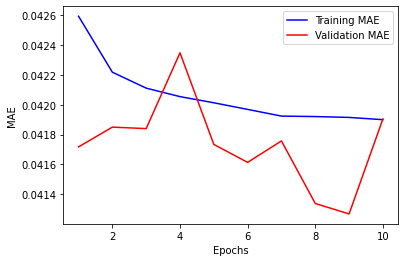

In [38]:
train_acc = training_history.history['mae']
val_acc = training_history.history['val_mae']

plt.xlabel('Epochs')
plt.ylabel('MAE')

plt.plot(np.arange(1,epok +1,1),training_history.history['mae'], label='Training MAE', color='blue')
plt.plot(np.arange(1,epok +1,1),training_history.history['val_mae'], label='Validation MAE', color='red')

plt.legend()

plt.show()

- On essaie avec un morceau au hasard

In [39]:
# On met en forme un morceau choisi hors liste d'entraînement.

n = 5
#hasard = VI_signal_mix[0:100000]
hasard = df.loc[94,'mixture']

ECH_mix = [[] for _ in range(nb_var)]                    

for k in range(nb_var):                                  
    data=[]                                              
    for i in range(k,len(hasard)-nb_var,nb_var):   
        data.append(hasard[i:i+nb_var])              
    ECH_mix[k].append(data)                              
    if len (ECH_mix[k][0])>nb_var:
        ECH_mix[k][0]=ECH_mix[k][0][:-1]
    

# On bâtit la liste contenant l'ensemble des prédictions    
vox_pred_deep =[]

for i in range (len(ECH_mix)):
    df_mix = None
   
    df_mix = pd.DataFrame(ECH_mix[i][0]).drop([nb_var-1],axis = 1)
        
    y = model_VI.predict(df_mix)
    
    vox_pred_deep.append(y)
    
# On reconstruit le signal
    
verif= pd.DataFrame(vox_pred_deep[0])
for i in range(1,len(ECH_mix)):
    verif = pd.concat([verif,pd.DataFrame(vox_pred_deep[i],columns=[i])],axis = 1)   
    
signal_reconstruit = np.asarray(verif).reshape(verif.shape[0]*verif.shape[1])
    
#signal_retard = np.concatenate([np.delete(signal_reconstruit,0),np.zeros(1)])
#signal_aval = np.concatenate([np.delete(signal_reconstruit,-1),np.zeros(1)])
    
#signal_temp = np.where(((np.absolute(signal_reconstruit)>5*np.absolute(signal_retard))&(np.absolute(signal_reconstruit)>5*np.absolute(signal_aval))), ((signal_retard+signal_aval)*0.5),signal_reconstruit)
    
 
#signal_bis = np.concatenate([zero,signal_temp]) 



In [40]:
zero = np.zeros(nb_var-1) 
signal_bis = np.concatenate([zero,signal_reconstruit]) 

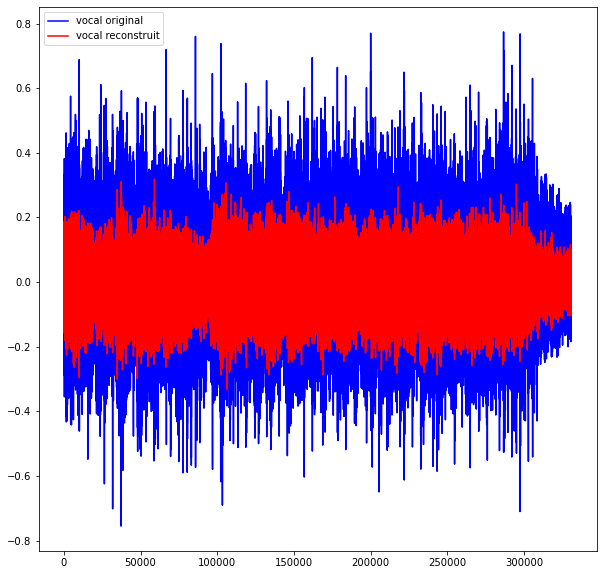

In [41]:
plt.figure(figsize =(10,10))
plt.plot(hasard,'b',label = 'vocal original')
plt.plot(signal_bis,'r',label = 'vocal reconstruit')
plt.legend()
plt.show()

In [42]:
# On écoute la prédiction
Audio(signal_bis,rate = 11025)

In [43]:
# On écoute
Audio(hasard,rate =11025)

## On essaie avec un modèle de régression polynomiale

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
 
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(VI_X_train)
 
# On entraîne notre modèle.    
    
model_poly = LinearRegression()
model_poly.fit(x_poly, VI_y_train)

LinearRegression()

In [28]:
# On prédit pour l'ensemble des p ensembles

vox_pred_poly =[]

for i in range (len(ECH_mix)):
    df_mix = None
   
    df_mix = pd.DataFrame(ECH_mix[i][0]).drop([nb_var-1],axis = 1)
    
    df_mix_poly = polynomial_features.fit_transform(df_mix)
    y = model_poly.predict(df_mix_poly)
    
    vox_pred_poly.append(y)

# On présente le résultat dans une dataframe
dictae = {}

for i in range(len(vox_pred_poly)):
    dictae[i] = vox_pred_poly[i]
    
verif_poly = pd.DataFrame.from_dict(dictae,orient = 'columns')

In [29]:
# On reconstruit le signal

signal_reconstruit_poly = np.asarray(verif_poly).reshape(verif_poly.shape[0]*verif_poly.shape[1])

# On moyenne le signal en cas de pic
signal_retard = np.concatenate([np.delete(signal_reconstruit_poly,0),np.zeros(1)])
signal_aval = np.concatenate([np.delete(signal_reconstruit_poly,-1),np.zeros(1)])
    
signal_temp = np.where(((np.absolute(signal_reconstruit_poly)>3*np.absolute(signal_retard))&(np.absolute(signal_reconstruit_poly)>3*np.absolute(signal_aval))), ((signal_retard+signal_aval)*0.5),signal_reconstruit_poly)
    
zero = np.zeros(n-1)  
signal_bis_poly = np.concatenate([zero,signal_temp]) 

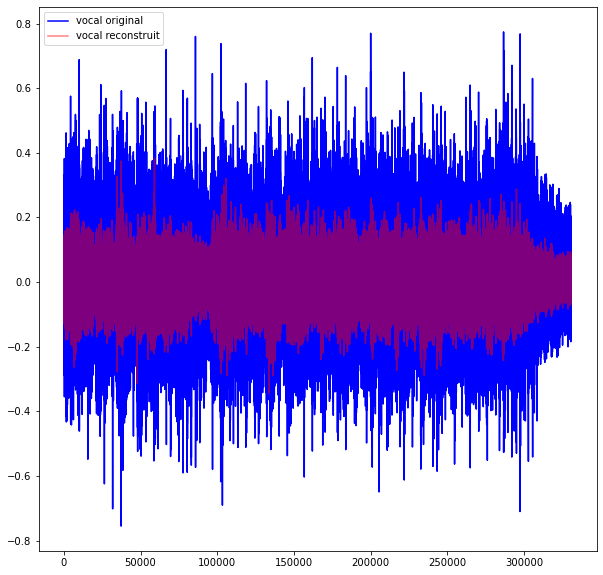

In [30]:
plt.figure(figsize =(10,10))
plt.plot(hasard,'b',label = 'vocal original')
plt.plot(signal_bis_poly,'r',alpha = 0.5,label = 'vocal reconstruit')
plt.legend()
plt.show()

In [31]:
Audio(signal_bis_poly,rate = 11025)

## Résultats et conclusions

- Pour le deep learning:
    - Musique toujours bien présente
    - Signal quasiment inchangé

- Pour le modèle de régression polynomial:
    - Musique toujours bien présente
    - Signal quasiment inchangé
- On en déduit que la différence d'amplitude entre le vocal et la mixture est trop faible pour espérer pouvoir prédire une valeur suffisamment "discriminante" par rapport au signal original; la fenêtre de prédicition donnant un signal identique à l'initial est trop importante